# MMD for two sample test

## Introduction

Throughout this file, we will deal with the problem of anomalies detection. <br>
Given a data set, the goal is to decide if each element of the data set is normal or anormal <br>
More formaly, we suppose that the normal datas are generated following a probability $p$, the observed data are generated following a probability $q$. The goal is to decide if $p=q$ or not.<br>
To answer this question we can use the $MMD_k(p,q)$.(Greton et al. 2012)<br>
$$
MMD_k(p,q) = ||\mu_p - \mu_q||^{2}_{F_k} = E_{xx'}k(x,x') + E_{yy'}k(y,y') - 2E_{xy}k(x,y)
$$
where :<br>
$k$ is a characteristic kernel<br>
$F_k$ is the Reproducing Kernel Hilbert Space associated to $k$ <br>
$\mu_p$ is the embeding of $p$ in $F_k$<br>
$x,x'$ following $p$ and $y,y'$ following $q$<br>
and $x,x',y,y'$ are independent

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import pandas as pd
from time import time
import os
os.chdir("/home/kronert/Documents/Python/Mémoire/Memoire")
from ipywidgets import interact

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)

Populating the interactive namespace from numpy and matplotlib


## Kernels

For the MMD-test we need Kernel who respect the characteristic property <br>
According to (Sriperumbudur et al. 2010) we will use the following's kernels.<br>
Gaussian kernel :
$$
k(x,y) = \exp\left(-\frac{||x-y||^{2}_{2}}{2\sigma}\right)
$$
Laplassian kernel:
$$
k(x,y) = \exp\left(-\sigma||x-y||_{1}\right)
$$

In [3]:
# Gaussian 
gaussian = lambda sigma: lambda x,y : np.exp(-np.linalg.norm(x-y,axis=1)**2/(2*sigma))
# Laplacian 
laplacian = lambda sigma: lambda x,y : np.exp(-sigma*np.linalg.norm(x-y,axis=1,ord=1))
#B2n+1-spline
#Bspline = lambda



Text(0.5,1,'Gaussian kernel')

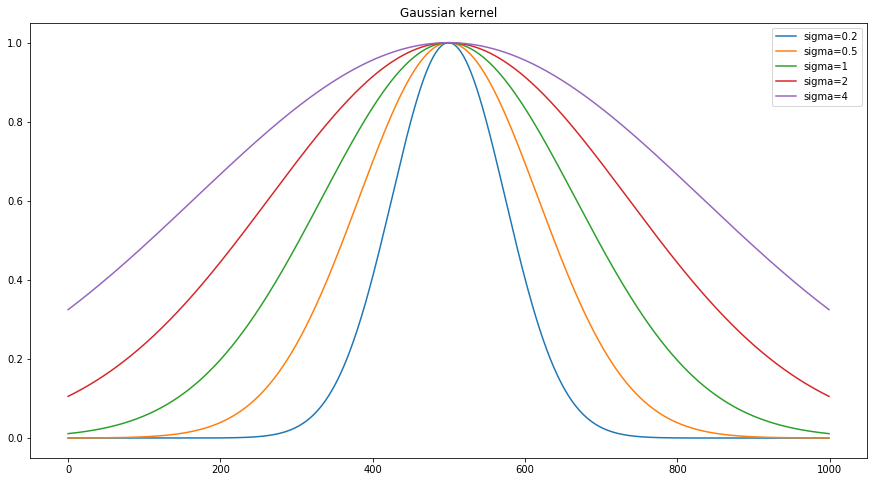

In [4]:
x = np.r_[-3:3:1000j].reshape((1000,1))
for sigma in [0.2,0.5,1,2,4]:
    plt.plot(gaussian(sigma)(x,0),label=f"sigma={sigma}")
plt.legend()
plt.title("Gaussian kernel")

Text(0.5,1,'laplacian kernel')

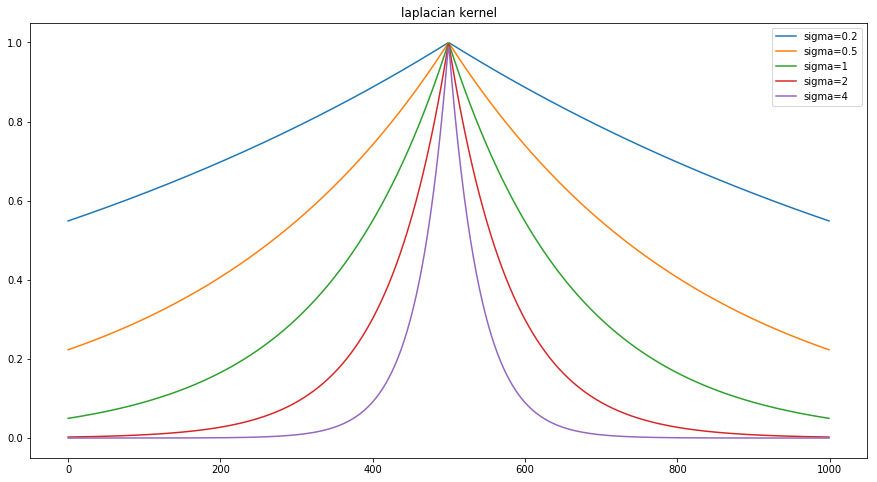

In [5]:
x = np.r_[-3:3:1000j].reshape((1000,1))
for sigma in [0.2,0.5,1,2,4]:
    plt.plot(laplacian(sigma)(x,0),label=f"sigma={sigma}")
plt.legend()
plt.title("laplacian kernel")

A convex combination of charactristic kernel is also a characteristic kernel.<br>
If $(k_i)_{1 \leq i \leq n}$ if a familly of characterisic kernels than : <br>
$$
\left\{ \sum_{0}^{n}t_ik_i~ s.a.~ \sum_{0}^{n}t_i = 1,ti\geq0 ~\forall i\right\} 
$$
Is a set of charactristics kernels.(Greton et al. 2012)




In [6]:
def CCK(kernels_list, weights_list):
    def kernel(x,y):
        res = 0
        for k,w in zip(kernels_list,weights_list):
            res += w*k(x,y)
        return res
    return  kernel

Text(0.5,1,'Convex Combination')

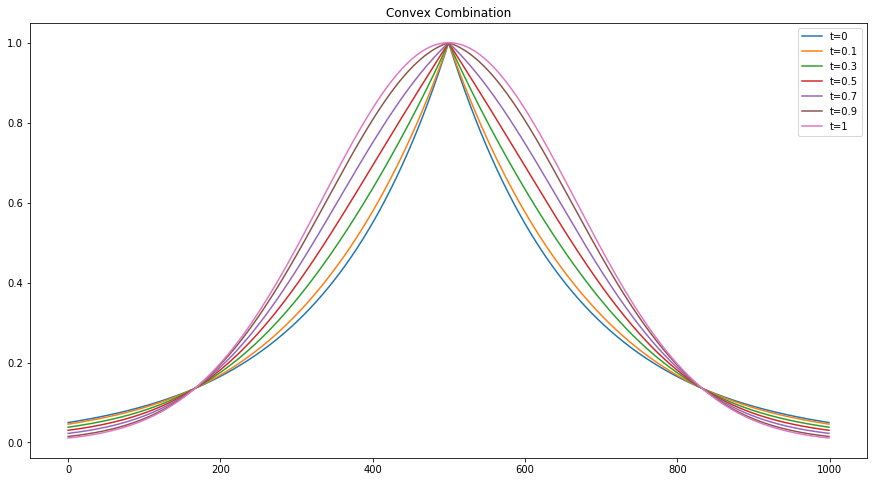

In [7]:
for t in [0,0.1,0.3,0.5,0.7,0.9,1]:
    kernel = CCK([gaussian(1),laplacian(1)],[t,1-t])
    plt.plot(kernel(x,0),label=f"t={t}")
plt.legend()
plt.title("Convex Combination")

## MMD Estimator

### Off line case

We suppose m=n <br>
There is two MMD Estimator.<br>
The MVUE estimator is the following :<br>
$$
MMD_q = \frac{1}{m(m-1)}\sum_{i\neq j}h_k(z_i,z_j) \\
h_k(z_i,z_j) = k(x_i,x_j) + k(y_i,y_j) - k(x_i,y_j) - k(y_i,x_j)
$$
However, this estimator is quadratic in time.<br>
We could also use a linear MMD Estimator
$$
MMD_l = \frac{2}{m}\sum_{i=0}^{m/2}h_k(v_i) \\
h_k(v_i) = k(x_{2i-1},x_{2i}) + k(y_{2i-1},y_{2i}) - k(x_{2i-1},y_{2i}) - k(x_{2i},y_{2i-1})
$$

#### Naive version

In the naive version, we only implement the method, explicitly with for loop

In [8]:
# Quadratic MMD
def MMDq_naive(X,Y,kernel):
    m = X.shape[0]
    n = Y.shape[0]
    res = 0
    for i in range(m):
        for j in range(m):
            if i != j:
                res += kernel(X[i].reshape((1,-1)),X[j].reshape((1,-1))) + kernel(Y[i].reshape((1,-1)),Y[j].reshape((1,-1))) - kernel(X[i].reshape((1,-1)),Y[j].reshape((1,-1))) - kernel(Y[i].reshape((1,-1)),X[j].reshape((1,-1)))
    return res/(m*(m-1))

# linear MMD     
def MMDl_naive(X,Y,kernel):
    m = X.shape[0]
    res = 0
    for i in range(0,int(m/2)):
        res += (kernel(X[2*i].reshape((1,-1)),X[2*i+1].reshape((1,-1))) 
               + kernel(Y[2*i].reshape((1,-1)),Y[2*i+1].reshape((1,-1))) 
               - kernel(X[2*i].reshape((1,-1)),Y[2*i+1].reshape((1,-1)))
               - kernel(Y[2*i].reshape((1,-1)),X[2*i+1].reshape((1,-1))))
    return 2*res/m

In [71]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))

t = time()
print(f"La valeur de la MMDq ={MMDq_naive(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

temps d'éxécution = 0.0001285076141357422


In [14]:
t = time()
print(f"La valeur de la MMDl ={MMDl_naive(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

La valeur de la MMDl =[-0.00511248]
temps d'éxécution = 0.18776822090148926


As we can see, the naive method is too slow, we seek a more effective method.

#### More effective method

The following method is inspired by the MapReduce method. <br>
Fisrt, we compute all the values of $ k(x_i, x_j)$ (map). <br>
The we compute the sum (reduce).

In [68]:
def MMDq(X,Y,kernel):
    m = X.shape[0]
    res = 0
    
    X_1,X_2 = np.meshgrid(X,X)
    m_,n_ = np.meshgrid(np.arange(0,m),np.meshgrid(np.arange(0,m)))
    X_, Y_ = X_1[n_!=m_].reshape(-1,1) ,X_2[n_!=m_].reshape(-1,1)
    res += kernel(X_,Y_).sum()/(m*(m-1))
    
    X_1,X_2 = np.meshgrid(Y,Y)
    m_,n_ = np.meshgrid(np.arange(0,m),np.meshgrid(np.arange(0,m)))
    X_, Y_ = X_1[n_!=m_].reshape(-1,1) ,X_2[n_!=m_].reshape(-1,1)
    res += kernel(X_,Y_).sum()/(m*(m-1))
    
    X_1,X_2 = np.meshgrid(X,Y)
    m_,n_ = np.meshgrid(np.arange(0,m),np.meshgrid(np.arange(0,m)))
    X_, Y_ = X_1[n_!=m_].reshape(-1,1) ,X_2[n_!=m_].reshape(-1,1)
    res -= 2*kernel(X_,Y_).sum()/(m*(m-1))
    
    return res

def MMDl(X,Y,kernel):
    m = X.shape[0]
    res = 0
    
    X_, Y_ = X[0::2,:],X[1::2,:]
    res += kernel(X_,Y_).sum()
    
    
    X_, Y_ = Y[0::2,:],Y[1::2,:]
    res += kernel(X_,Y_).sum()
    
    X_, Y_ = X[0::2,:],Y[1::2,:]
    res -= kernel(X_,Y_).sum()
    
    X_, Y_ = Y[0::2,:],X[1::2,:]
    res -= kernel(X_,Y_).sum()
    
    return 2*res/m

In [72]:
t = time()
print(f"La valeur de la MMDq ={MMDq(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

La valeur de la MMDq =-0.0003140304771447333
temps d'éxécution = 0.4430675506591797


In [73]:
t = time()
print(f"La valeur de la MMDl ={MMDl(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

La valeur de la MMDl =0.04477630956952101
temps d'éxécution = 0.007008790969848633


The second method is far more effective (20x less time), and we can check that is compute the same function.

### First Experiments

As we have, effective method to compute the MMD, we can yet compute, the MMD for some cases to make first statistics.<br>
By using the following programm's, we compute a sample for MMD.

In [132]:
dataset = pd.DataFrame(columns=["MethMMD","Kernel","size","parametre","perturbation","mmd","time"])

MethMMD = ['MMDl','MMDq']
MMD = {}
MMD['MMDl'] = MMDl
MMD['MMDq'] = MMDq

Kernel = ['gaussian','laplacian']
Ker = {}
Ker['gaussian'] = gaussian
Ker['laplacian'] = laplacian

parametre = [0.25, 0.5, 1, 2, 5]

size = [10,50,100,500,1000]

m = 100
n = 0
for i in range(m):
    for s in size:
        X = np.random.randn(s).reshape((s,1))
        Y = np.random.randn(s).reshape((s,1))
        T = np.random.uniform(low= -np.sqrt(3),high=np.sqrt(3),size=s).reshape((s,1))
        for Mmd in MethMMD:
            for kernel in Kernel:
                for p in parametre:
                   
                    
                    t = time()
                    mmd = MMD[Mmd](X,Y,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'same',s,mmd,t]
                    n+=1
                    
                    t = time()
                    mmd = MMD[Mmd](X,Y+1,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'mu+1',s,mmd,t]
                    n+=1
                    
                    t = time()
                    mmd = MMD[Mmd](X,Y*2,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'std*2',s,mmd,t]
                    n+=1
                    
                    t = time()
                    mmd = MMD[Mmd](X,T,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'unif_law',s,mmd,t]
                    n+=1
        print(s)
    print(i)

dataset.to_csv("MMD_data.csv", encoding='utf-8', index=False)  

10
50
100
500
1000
0
10
50
100
500
1000
1
10
50
100
500
1000
2
10
50
100
500
1000
3
10
50
100
500
1000
4
10
50
100
500
1000
5
10
50
100
500
1000
6
10
50
100
500
1000
7
10
50
100
500
1000
8
10
50
100
500
1000
9
10
50
100
500
1000
10
10
50
100
500
1000
11
10
50
100
500
1000
12
10
50
100
500
1000
13
10
50
100
500
1000
14
10
50
100
500
1000
15
10
50
100
500
1000
16
10
50
100
500
1000
17
10
50
100
500
1000
18
10
50
100
500
1000
19
10
50
100
500
1000
20
10
50
100
500
1000
21
10
50
100
500
1000
22
10
50
100
500
1000
23
10
50
100
500
1000
24
10
50
100
500
1000
25
10
50
100
500
1000
26
10
50
100
500
1000
27
10
50
100
500
1000
28
10
50
100
500
1000
29
10
50
100
500
1000
30
10
50
100
500
1000
31
10
50
100
500
1000
32
10
50
100
500
1000
33
10
50
100
500
1000
34
10
50
100
500
1000
35
10
50
100
500
1000
36
10
50
100
500
1000
37
10
50
100
500
1000
38
10
50
100
500
1000
39
10
50
100
500
1000
40
10
50
100
500
1000
41
10
50
100
500
1000
42
10
50
100
500
1000
43
10
50
100
500
1000
44
10
50
100
500
1000
4

NameError: name 'datasetto_csv' is not defined

We get the saving data

In [137]:
#dataset.to_csv("MMD_data.csv", encoding='utf-8', index=False)  
data_experiment = pd.read_csv('MMD_data.csv')

### Explore the Data

In [138]:
data_experiment.head()

,MethMMD,Kernel,parametre,perturbation,size,mmd,time
0,MMDl,gaussian,0.25,same,10,0.334307,0.000538
1,MMDl,gaussian,0.25,mu+1,10,0.512887,0.000473
2,MMDl,gaussian,0.25,std*2,10,0.202952,0.000503
3,MMDl,gaussian,0.25,unif_law,10,0.308257,0.000771
4,MMDl,gaussian,0.50,same,10,0.312142,0.000452


In [139]:
data_experiment.describe()

,parametre,size,mmd,time
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.750000,332.000000,0.047192,0.033147
std,1.732072,377.226136,0.100523,0.081201
min,0.250000,10.000000,-0.734751,-0.777871
25%,0.500000,50.000000,-0.000586,0.000535
50%,1.000000,100.000000,0.029843,0.001447
75%,2.000000,500.000000,0.094236,0.003823
max,5.000000,1000.000000,0.967662,0.905150


#### Complexity in time

In [140]:
@interact(methode=["MMDq","MMDl"])
def complexity(methode):
    return sea.lineplot(x='size',y='time',data=data_experiment[data_experiment['MethMMD']==methode])

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Output()), _dom…

#### Distribution

In [141]:
@interact(methode=["MMDq","MMDl"],perturbation=["same","mu+1","std*2","unif_law"],kernel=["gaussian","laplacian"],
          size=[10,50,100,500,1000],parametre=[0.25, 0.5, 1, 2, 5])
def complexity(methode,perturbation,kernel,size,parametre):
    return sea.kdeplot(data=data_experiment[data_experiment['MethMMD']==methode][data_experiment['size']==size][data_experiment['Kernel']==kernel][data_experiment['perturbation']==perturbation][data_experiment['parametre']==parametre]['mmd'])

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Dropdown(descri…

#### Separation

In [143]:
@interact(methode=["MMDq","MMDl"],kernel=["gaussian","laplacian"],parametre=[0.25, 0.5, 1, 2, 5])
def complexity(methode,kernel,parametre):
    return sea.lineplot(x='size',y='mmd',data=data_experiment[data_experiment['MethMMD']==methode][data_experiment['Kernel']==kernel][data_experiment['parametre']==parametre],hue="perturbation")

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Dropdown(descri…

In [144]:
@interact(methode=["MMDq","MMDl"],kernel=["gaussian","laplacian"],parametre=[0.25, 0.5, 1, 2, 5],q=["mu+1","std*2","unif_law"],size=50)
def complexity(methode,kernel,parametre,q,size):
    return sea.violinplot(x='size',y='mmd',data=pd.concat([data_experiment[data_experiment['perturbation']==q],data_experiment[data_experiment['perturbation']=="same"]])[data_experiment['MethMMD']==methode][data_experiment['Kernel']==kernel][data_experiment['size']>=size],hue="perturbation",split=True)

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Dropdown(descri…

### Treshold Estimator

For the treshold estimator base on condition that error A should arrive with probability of 5%.<br>
We build an estimator of the 95th centile, with bootstrap method, with $H_0$ hypotesis.

In [145]:
def treshold_estimator(X,MMD,m, nb_turn = 100):
    mmd_list = []
    for i in range(nb_turn):
        x = np.random.choice(X, size = m, replace=True)
        y = np.random.choice(X, size = m, replace=True)
        mmd_list.append(abs(MMD(x.reshape((m,-1)),y.reshape((m,-1)))))
    mmd_list.sort()
    return mmd_list[int(95*nb_turn/100)]

In [146]:
X = np.random.randn(1000)
treshold_estimator(X,lambda x,y : MMDl(x,y,gaussian(1)),100,nb_turn=10000)

0.15052994218719498

#### Linear MMD case

By using that $m^{1/2}(MMDl - MMD(p,q)) \rightarrow N(0,2\sigma)$ in law in the case of $H_0$ hypotesis.<br>
$ t_{\alpha} = m^{-1/2}\sigma\sqrt{2} \Phi^{-1}(1-\alpha)$ where $\sigma$ is the standart deviation of $h$.<br>
(Gretton et al., 2012)
When $\alpha = 0.05$ then $\Phi^{-1}(1-\alpha) = 1.64$

In [147]:
def h_std_estimator(X,kernel, nb_turn = 100):
    x = X[:X.shape[0]//2,:]
    y = X[X.shape[0]//2:,:]
    indices = np.arange(0,X.shape[0]//2,2)
    h_list = []
    for _ in range(nb_turn):
        i = np.random.choice(indices, size = 1, replace=True)
        h_list.append(kernel(x[i],x[i+1]) + kernel(y[i],y[i+1]) - kernel(y[i],x[i+1]) - kernel(x[i],y[i+1]))
    return np.std(h_list)

In [148]:
X = np.random.randn(1000).reshape((1000,1))
h_std_estimator(X,gaussian(1),nb_turn=10000)*1.14*1.64/(100)**0.5


0.10005727868915848

### Experience Off line

In [150]:
X = np.random.randn(1000)
size = [10,50,100,500,1000]
L = []
M = []
MMD = lambda x,y : MMDl(x,y,gaussian(1))
for s in size:
    L.append(treshold_estimator(X,MMD,s, nb_turn = 100))
    M.append(h_std_estimator(X.reshape((1000,1)),gaussian(1), nb_turn = 100)*1.14*1.64/(s)**0.5)

@interact(methode=["MMDq","MMDl"],kernel=["gaussian","laplacian"],parametre=[0.25, 0.5, 1, 2, 5])
def complexity(methode,kernel,parametre):
    plt.plot(size, L, 'k-',label="95%_treshold")
    plt.plot(size, M, 'y-',label="std_threshold")

    return sea.lineplot(x='size',y='mmd',data=data_experiment[data_experiment['MethMMD']==methode][data_experiment['Kernel']==kernel],hue="perturbation")

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Dropdown(descri…

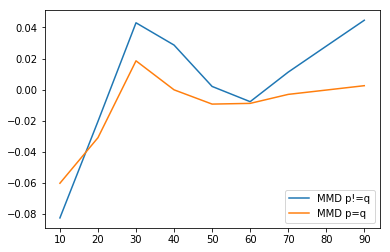

In [218]:
plt.plot(range(10,100,10),MMDliste,label="MMD p!=q")
plt.plot(range(10,100,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Mean modification - linear MMD

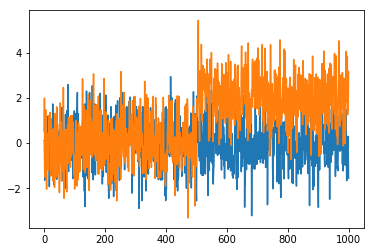

In [220]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
T = np.hstack(((np.random.randn(500),np.random.randn(500)+2))).reshape((1000,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = CCK([gaussian(1),laplacian(1)],[0.7,0.3])
for i in range(10,1000,10):
    MMDliste.append(MMDl(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDl(X[:i],Y[:i],kernel))


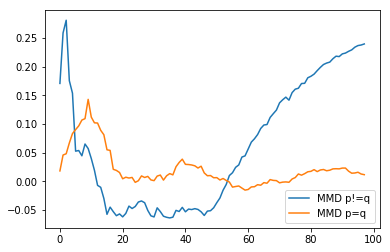

In [221]:
plt.plot(MMDliste[1:],label="MMD p!=q")
plt.plot(MMDTemmoin[1:],label="MMD p=q")
plt.legend()

#### Variance Modification - quadratic MMD

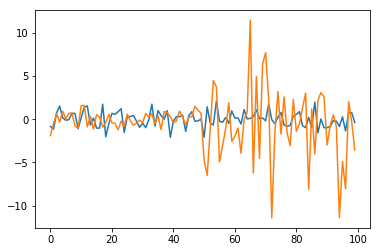

In [222]:
X = np.random.randn(100).reshape((100,1))
Y = np.random.randn(100).reshape((100,1))
T = np.hstack(((np.random.randn(50),np.random.randn(50)*5))).reshape((100,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(10,100,10):
    MMDliste.append(MMDq(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDq(X[:i],Y[:i],kernel))

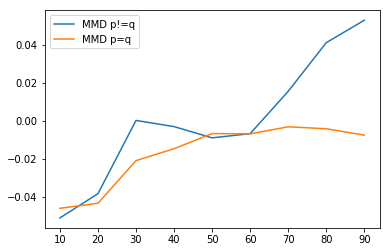

In [223]:
plt.plot(range(10,100,10),MMDliste,label="MMD p!=q")
plt.plot(range(10,100,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Variance Modification - Linear MMD

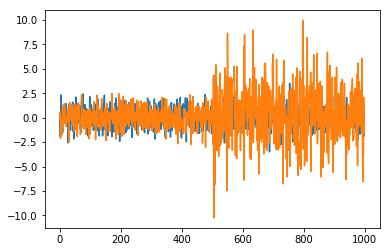

In [224]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
T = np.hstack(((np.random.randn(500),np.random.randn(500)*3))).reshape((1000,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(200,1000,10):
    MMDliste.append(MMDl(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDl(X[:i],Y[:i],kernel))

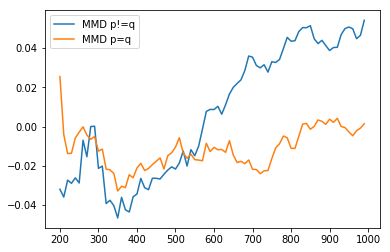

In [225]:
plt.plot(range(200,1000,10),MMDliste,label="MMD p!=q")
plt.plot(range(200,1000,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Law modification - Quadratic MMD

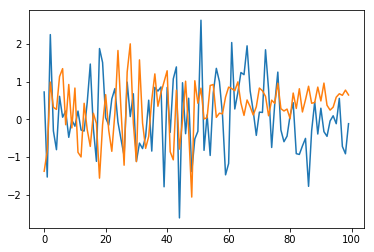

In [226]:
X = np.random.randn(100).reshape((100,1))
Y = np.random.randn(100).reshape((100,1))
T = np.hstack(((np.random.randn(50),np.random.uniform(size=50)))).reshape((100,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(10,100,10):
    MMDliste.append(MMDq(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDq(X[:i],Y[:i],kernel))

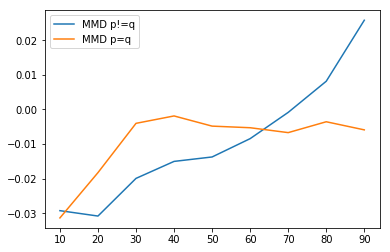

In [227]:
plt.plot(range(10,100,10),MMDliste,label="MMD p!=q")
plt.plot(range(10,100,10),MMDTemmoin,label="MMD p=q")
plt.legend()

#### Law Modification - Linear MMD

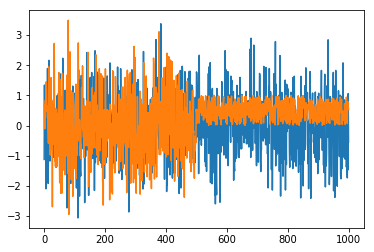

In [228]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
T = np.hstack(((np.random.randn(500),np.random.uniform(size=500)))).reshape((1000,1))
plt.plot(X)
plt.plot(T) 
MMDliste = []
MMDTemmoin = []
kernel = gaussian(1)
for i in range(200,1000,10):
    MMDliste.append(MMDl(X[:i],T[:i],kernel))
    MMDTemmoin.append(MMDl(X[:i],Y[:i],kernel))

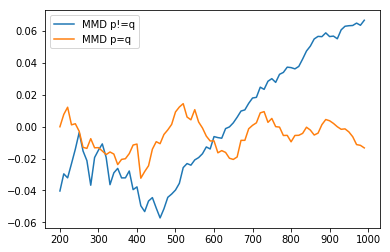

In [229]:
plt.plot(range(200,1000,10),MMDliste,label="MMD p!=q")
plt.plot(range(200,1000,10),MMDTemmoin,label="MMD p=q")
plt.legend()

### On line case

We suppose m > n <br>
The quadratic estimator is the following :<br>
$$
MMD_u = \frac{1}{m^2}\sum k(x_i,x_j) + \frac{1}{n^2}\sum k(y_i,y_j) - \frac{2}{nm}\sum k(x_i,y_j) \\
$$
This is a baised estimator.<br>
We could also use a linear MMD Estimator ??
$$
MMD_l = \frac{2}{m}\sum_{i=0}^{m/2}k(x_{2i},x_{2i-1}) + \frac{2}{n}\sum_{i=0}^{n/2}k(y_{2i},y_{2i-1}) - \frac{2}{n}\sum_{i=0}^{n/2}k(x_{2i},y_{2i-1}) - \frac{2}{n}\sum_{i=0}^{n/2}k(y_{2i},x_{2i-1}) \\
$$

## Références

GRETTON, Arthur, SEJDINOVIC, Dino, STRATHMANN, Heiko, et al. Optimal kernel choice for large-scale two-sample tests. In : Advances in neural information processing systems. 2012. p. 1205-1213

Sriperumbudur, B. K., Gretton, A., Fukumizu, K., Schölkopf, B., & Lanckriet, G. R. (2010). Hilbert space embeddings and metrics on probability measures. Journal of Machine Learning Research, 11(Apr), 1517-1561.